In [ ]:
#import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import math

Mounted at /content/drive


In [ ]:
from scipy.stats import boxcox
from scipy.stats import skew

In [ ]:
os.chdir('/content/drive/MyDrive/SKY Content') #change to your location

In [ ]:
df=pd.read_csv ('SF_1118_last.csv')

In [ ]:
df.head()

,random_id,nb_session_users,wax_farmed,chat_msg,candle_accepted_cost,candle_received_cost,nb_new_friends,duration_in_sec,age,gender,race
0,JbiuObqgRG2L9SjNrTfN7g,42,1.0,7.0,NaN,NaN,0,333,100,Male,White
1,baWnmY-aSZ6DHST_-UqJjg,5,NaN,NaN,NaN,NaN,0,81,34,Female,Asian
2,JbiuObqgRG2L9SjNrTfN7g,5,NaN,NaN,NaN,NaN,0,17,100,Male,White
3,JbiuObqgRG2L9SjNrTfN7g,6,NaN,NaN,NaN,NaN,0,60,100,Male,White
4,JbiuObqgRG2L9SjNrTfN7g,7,85.0,1.0,NaN,NaN,0,230,100,Male,White


In [ ]:
df.fillna(0)

,random_id,nb_session_users,wax_farmed,chat_msg,candle_accepted_cost,candle_received_cost,nb_new_friends,duration_in_sec,age,gender,race
0,JbiuObqgRG2L9SjNrTfN7g,42,1.0,7.0,0.0,0.0,0,333,100,Male,White
1,baWnmY-aSZ6DHST_-UqJjg,5,0.0,0.0,0.0,0.0,0,81,34,Female,Asian
2,JbiuObqgRG2L9SjNrTfN7g,5,0.0,0.0,0.0,0.0,0,17,100,Male,White
3,JbiuObqgRG2L9SjNrTfN7g,6,0.0,0.0,0.0,0.0,0,60,100,Male,White
4,JbiuObqgRG2L9SjNrTfN7g,7,85.0,1.0,0.0,0.0,0,230,100,Male,White
...,...,...,...,...,...,...,...,...,...,...,...
7579583,8qNjN-VOS-uLahl81hOqZA,7,99.0,0.0,0.0,0.0,0,136,36,Male,Asian
7579584,8qNjN-VOS-uLahl81hOqZA,0,0.0,0.0,0.0,0.0,0,63,36,Male,Asian
7579585,8qNjN-VOS-uLahl81hOqZA,5,1.0,0.0,0.0,0.0,0,266,36,Male,Asian
7579586,4FgVALOXSDmUbKxQrCmk7Q,0,0.0,0.0,0.0,0.0,0,0,36,Male,White


In [ ]:
# List of columns to convert to category dtype
columns_to_convert = [
    'gender', 'race'
]

# Convert specified columns to 'category' type using a loop
df[columns_to_convert] = df[columns_to_convert].astype('category')

In [ ]:
sum_columns = [
    'wax_farmed', 'chat_msg',
    'candle_accepted_cost', 'candle_received_cost',  'nb_new_friends','duration_in_sec'
]
avg_columns = [
    'nb_session_users'
]

aggregated_df = df.groupby('random_id').agg(
    {**{col: 'sum' for col in sum_columns},
     **{col: 'mean' for col in avg_columns},
     **{col: 'last' for col in df.columns if col not in sum_columns + avg_columns + ['random_id']}}
).reset_index()


In [ ]:
assert aggregated_df['random_id'].nunique() == len(aggregated_df), "Some random_ids still have multiple rows."

In [ ]:
aggregated_df.shape

(13419, 11)

In [ ]:
forward_transform  = lambda x: np.log10(x) #to compress or normalize data that has a wide range of values, making the distribution more manageable.
backward_transform = lambda x: 10**x #This function is the inverse of the forward transform.

In [ ]:
#data smoothing

In [ ]:
# 需要做log转换的列
columns_to_transform_forward = [
    'wax_farmed',
    'chat_msg'
]

# 在转换前处理0值（因为log10(0)是未定义的）
for col in columns_to_transform_forward:
    # 给0值加一个很小的数
    aggregated_df[col] = aggregated_df[col].replace(0, 0.1)
    # 应用log转换
    aggregated_df[col] = aggregated_df[col].apply(forward_transform)


In [ ]:
aggregated_df.describe()

,wax_farmed,chat_msg,candle_accepted_cost,candle_received_cost,nb_new_friends,duration_in_sec,nb_session_users,age
count,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,1.341900e+04,13419.000000,1.341900e+04
mean,3.920637,2.402986,16.089276,17.355988,2.954095,1.243618e+05,5.449341,2.514037e+14
std,0.683116,1.313670,22.001516,23.020325,3.902521,1.063053e+05,1.840691,1.644461e+16
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3.727623,1.903090,1.000000,2.000000,0.000000,4.264100e+04,4.515306,1.600000e+01
50%,4.152472,2.795185,8.000000,9.000000,2.000000,1.024680e+05,5.293296,1.900000e+01
75%,4.361898,3.328482,23.000000,25.000000,4.000000,1.786740e+05,6.165504,2.300000e+01
max,4.482459,4.435669,420.000000,515.000000,40.000000,1.067140e+06,54.000000,1.234563e+18


In [ ]:
aggregated_df = aggregated_df[aggregated_df['age'] <= 99]

In [ ]:
Features= aggregated_df

In [ ]:
df1=pd.read_csv('NWK_last.csv')

In [ ]:
pair_counts = df1.groupby(['random_id', 'nearby_id']).size().reset_index(name='Times')

# Sort values by Times in descending order
result_df = pair_counts.sort_values('Times', ascending=False)

In [ ]:
result_df.shape

(698369, 3)

In [ ]:
result_df.to_csv('sky_11_18_network_clean')

In [ ]:
ValueFeaturesFile =VF= Features
NetworkFile = NF = pd.read_csv('sky_11_18_network_clean')

In [ ]:
Features.shape

(13306, 11)

In [ ]:
# clean the dataframes to only remain the duplicates

nf_ids = set(NF['random_id']).union(set(NF['nearby_id']))

VF_filtered = VF[VF['random_id'].isin(nf_ids)]

VF = VF_filtered.reset_index(drop=True)

In [ ]:
ids = VF['random_id']
allnetwork = set(list(NF['random_id']) + list(NF['nearby_id']))
#This line extracts and combines two columns, Source Node and Target Node, from DataFrame NF. Then, concatenates the two lists into a single list containing all the elements from both columns.

In [ ]:
ids = set(list(ids))#converts ids into a Python nts in ids.

In [ ]:
len(allnetwork)

13152

In [ ]:
len(ids-allnetwork)
#The len() function then calculates the number of unique elements in this set difference, indicating how many elements in ids are not present in allnetwork

0

In [ ]:
len(NF.index)
#the len() function counts the total number of row indices, which is equivalent to the number of rows in NF.

698369

In [ ]:
svdata = VF
ndata = NF
svdata.columns

Index(['random_id', 'wax_farmed', 'chat_msg', 'candle_accepted_cost',
       'candle_received_cost', 'nb_new_friends', 'duration_in_sec',
       'nb_session_users', 'age', 'gender', 'race'],
      dtype='object')

In [ ]:
svdata.head()

,random_id,wax_farmed,chat_msg,candle_accepted_cost,candle_received_cost,nb_new_friends,duration_in_sec,nb_session_users,age,gender,race
0,--2D1MYIR4SYjrzuFwMu8Q,3.463744,2.328380,44.0,10.0,5,33895,6.885542,17,Female,White
1,--DgfqESR-2a9m2y0qj13Q,4.368138,3.214844,8.0,15.0,0,249766,6.854916,18,Male,"White, Black"
2,--d4OGusRKWeVde_VhRZMA,3.920332,1.662758,0.0,2.0,2,60773,4.743017,32,Female,Asian
3,--gEQZL9TlmrOFX1nepvhw,4.095169,3.673574,6.0,12.0,0,155636,6.784029,15,Female,White
4,--smEAAiT2yfJa_igl_T0A,3.669503,2.413300,14.0,2.0,1,57494,3.901015,16,Male,Asian


In [ ]:
del svdata['gender']
del svdata['race']

In [ ]:
ndata.head()

,Unnamed: 0,random_id,nearby_id,Times
0,9567,-n1WUxnYQvKg4udMi31YkA,gcTi7IPdT1um0iqas3BBfA,1198
1,490148,gcTi7IPdT1um0iqas3BBfA,-n1WUxnYQvKg4udMi31YkA,1159
2,535980,ki69Moy3Re2QZIFmbL-uXg,qVwF_dHTTgKHEPcMRbq7_A,1054
3,598262,qVwF_dHTTgKHEPcMRbq7_A,ki69Moy3Re2QZIFmbL-uXg,1042
4,264196,NCKGLWUbTs2n-4jxYj-SIw,ZV2PqX7qS5mEkjGtkZe-VA,1018


Box-Cox Lambda: 0.37037490533412104
Skewness (Box-Cox transformation): -0.07598796130875017


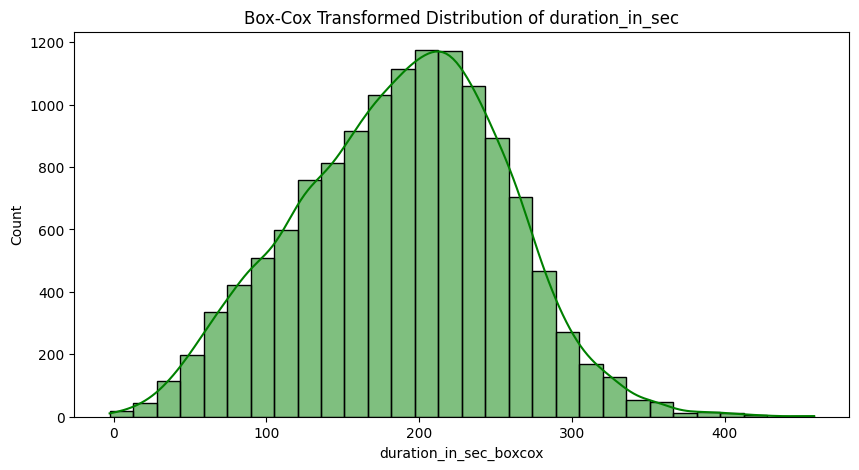

In [ ]:
svdata['duration_in_sec_positive'] = svdata['duration_in_sec'] + 1e-6  # 添加一个小值以确保数据为正
svdata['duration_in_sec_boxcox'], fitted_lambda = boxcox(svdata['duration_in_sec_positive'])
print("Box-Cox Lambda:", fitted_lambda)
print("Skewness (Box-Cox transformation):", skew(svdata['duration_in_sec_boxcox']))

# 可视化 Box-Cox 变换后的分布
plt.figure(figsize=(10, 5))
sns.histplot(svdata['duration_in_sec_boxcox'], kde=True, bins=30, color='green')
plt.title("Box-Cox Transformed Distribution of duration_in_sec")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Exclude 'random_id' for transformations as it is the ID column
non_id_columns = svdata.columns.difference(['random_id'])

# Fill missing values for numerical columns
for column in svdata[non_id_columns].select_dtypes(include=['float64', 'int64']).columns:
    svdata[column].fillna(svdata[column].median(), inplace=True)

# Fill missing values for categorical/object columns
for column in svdata[non_id_columns].select_dtypes(include=['category', 'object']).columns:
    svdata[column].fillna(svdata[column].mode()[0], inplace=True)

# Apply label encoding for columns with more than 4 unique values
label_encoders = {}
for column in svdata[non_id_columns].select_dtypes(include=['category', 'object']).columns:
    if svdata[column].nunique() > 4:
        le = LabelEncoder()
        svdata[column] = le.fit_transform(svdata[column])
        label_encoders[column] = le
        print(f"Applied label encoding to {column}")
    else:
        print(f"Applied one-hot encoding to {column}")

# Apply one-hot encoding for remaining categorical columns with <= 4 categories
columns_to_encode = [
    col for col in svdata[non_id_columns].select_dtypes(include=['category', 'object']).columns
    if svdata[col].nunique() <= 4
]
svdata = pd.get_dummies(svdata, columns=columns_to_encode, drop_first=True)

print("Data after encoding:\n", svdata.head())
svdata.head()


Data after encoding:
                 random_id  wax_farmed  chat_msg  candle_accepted_cost  \
0  --2D1MYIR4SYjrzuFwMu8Q    3.463744  2.328380                  44.0   
1  --DgfqESR-2a9m2y0qj13Q    4.368138  3.214844                   8.0   
2  --d4OGusRKWeVde_VhRZMA    3.920332  1.662758                   0.0   
3  --gEQZL9TlmrOFX1nepvhw    4.095169  3.673574                   6.0   
4  --smEAAiT2yfJa_igl_T0A    3.669503  2.413300                  14.0   

   candle_received_cost  nb_new_friends  duration_in_sec  nb_session_users  \
0                  10.0               5            33895          6.885542   
1                  15.0               0           249766          6.854916   
2                   2.0               2            60773          4.743017   
3                  12.0               0           155636          6.784029   
4                   2.0               1            57494          3.901015   

   age  duration_in_sec_positive  duration_in_sec_boxcox  
0   17     

<ipython-input-36-2dd3cf7fa9ff>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  svdata[column].fillna(svdata[column].median(), inplace=True)


,random_id,wax_farmed,chat_msg,candle_accepted_cost,candle_received_cost,nb_new_friends,duration_in_sec,nb_session_users,age,duration_in_sec_positive,duration_in_sec_boxcox
0,--2D1MYIR4SYjrzuFwMu8Q,3.463744,2.328380,44.0,10.0,5,33895,6.885542,17,33895.000001,125.889976
1,--DgfqESR-2a9m2y0qj13Q,4.368138,3.214844,8.0,15.0,0,249766,6.854916,18,249766.000001,266.744543
2,--d4OGusRKWeVde_VhRZMA,3.920332,1.662758,0.0,2.0,2,60773,4.743017,32,60773.000001,156.933827
3,--gEQZL9TlmrOFX1nepvhw,4.095169,3.673574,6.0,12.0,0,155636,6.784029,15,155636.000001,223.444371
4,--smEAAiT2yfJa_igl_T0A,3.669503,2.413300,14.0,2.0,1,57494,3.901015,16,57494.000001,153.687948


In [ ]:

targetVariable = svdata.columns.get_loc("duration_in_sec")
socialFeatures = [
    "Nb_session_users", "nearby_friend_start", "nearby_friend_end", "if_social",
    "candle_accepted_cost", "candle_received_cost", "giftmessage_recv",
    "giftmessage_send", "nb_new_friends"
]
idColumn = svdata.columns.get_loc("random_id")
EmptyNeighborhoodFeatureValues = [0] * len(socialFeatures)

a = set(range(len(svdata.columns)))
b = {idColumn, targetVariable}
c = list(a - b)

svdatax = svdata.iloc[:, c]
svdatay = svdata.iloc[:, targetVariable]

nTree = 100
sampFrac = 0.25
numsamples = math.ceil(sampFrac * len(svdatax.index))

print("Data preparation and initial setup complete")
print(svdatax.head(), svdatay.head())
svdatax.columns

Data preparation and initial setup complete
   wax_farmed  chat_msg  candle_accepted_cost  candle_received_cost  \
0    3.463744  2.328380                  44.0                  10.0   
1    4.368138  3.214844                   8.0                  15.0   
2    3.920332  1.662758                   0.0                   2.0   
3    4.095169  3.673574                   6.0                  12.0   
4    3.669503  2.413300                  14.0                   2.0   

   nb_new_friends  nb_session_users  age  duration_in_sec_positive  \
0               5          6.885542   17              33895.000001   
1               0          6.854916   18             249766.000001   
2               2          4.743017   32              60773.000001   
3               0          6.784029   15             155636.000001   
4               1          3.901015   16              57494.000001   

   duration_in_sec_boxcox  
0              125.889976  
1              266.744543  
2              156.93382

Index(['wax_farmed', 'chat_msg', 'candle_accepted_cost',
       'candle_received_cost', 'nb_new_friends', 'nb_session_users', 'age',
       'duration_in_sec_positive', 'duration_in_sec_boxcox'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics
import numpy as np
import pandas as pd

# Model training
print("Building forest...")
rf = RandomForestRegressor(n_estimators=nTree)
rf.fit(svdatax, svdatay)
y_pred_rf = rf.predict(svdatax)
print("Model training complete.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(svdatax, svdatay, test_size=0.20, random_state=3)
r2_score = sklearn.metrics.r2_score(svdatay, y_pred_rf)

# Handling zero values and computing log
y_actual = svdatay.copy().replace(to_replace=0, value=0.01)
logged_y_actual = list(np.log10(y_actual))
h = np.histogram(logged_y_actual)
breaks = h[1]
bin_no = [-1] * len(logged_y_actual)

# Bin assignment
for j in range(len(logged_y_actual)):
    num = logged_y_actual[j]
    flag = False
    for i in range(len(breaks) - 1):
        left, right = breaks[i], breaks[i + 1]
        if left <= num < right:
            bin_no[j] = 10**i
            flag = True
            break
    if not flag and num == breaks[-1]:
        bin_no[j] = 10**(len(breaks) - 1)

# Convert y_actual to a numpy array for consistent indexing
y_actual_values = y_actual.values

# Calculate relative error and accuracy
smoothing_factor = 0.01
relative_error = [
    abs(y_actual_values[i] - y_pred_rf[i]) / (y_actual_values[i] + smoothing_factor) * bin_no[i]
    for i in range(len(y_actual_values))
]
weighted_err = sum(relative_error) / sum(bin_no)
accuracy_perc = 100 - weighted_err * 100

# Output results
print("R2 Score:", r2_score)
print("Accuracy Percentage:", accuracy_perc)


Building forest...
Model training complete.
R2 Score: 0.9999687332908513
Accuracy Percentage: 99.98095554795347


                     dest  NetworkPower_dest
0  --2D1MYIR4SYjrzuFwMu8Q               7.46
1  --DgfqESR-2a9m2y0qj13Q              11.85
2  --d4OGusRKWeVde_VhRZMA               2.55
3  --gEQZL9TlmrOFX1nepvhw              12.20
4  --smEAAiT2yfJa_igl_T0A               3.17


<ipython-input-39-c31306ccbdb2>:28: FutureWarning: The provided callable <function sum at 0x79f0a4ff4670> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped = ndata.groupby('dest').aggregate(np.sum).reset_index()
<ipython-input-39-c31306ccbdb2>:49: FutureWarning: The provided callable <function sum at 0x79f0a4ff4670> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  svresult = ewsvresult.groupby('src').aggregate(np.sum).reset_index()
<ipython-input-39-c31306ccbdb2>:52: FutureWarning: The provided callable <function sum at 0x79f0a4ff4670> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  infresult = ewsvresult.g

Statistical DataFrame:
              Metric  Min           Max            Std           Mean  \
0      Social Value  0.0  4.609905e+03      92.858080      18.999775   
1     Asocial Value  0.0  1.012839e+06  106122.972980  125898.115036   
2  Influenceability  0.0  5.596787e+04     693.502060      18.999775   
3     Network Power  0.0  1.012874e+06  106137.821150  125917.114811   
4    Personal Spend  0.0  1.067140e+06  106226.347390  125917.114811   
5       Total Value  0.0  1.067175e+06  106241.187825  125936.114586   

          Total  
0  2.498850e+05  
1  1.655812e+09  
2  2.498850e+05  
3  1.656062e+09  
4  1.656062e+09  
5  1.656312e+09  
Social Percentage: 0.0150891123638159
R2 Score: 0.9999687332908513
Accuracy Percentage: 99.98095554795347


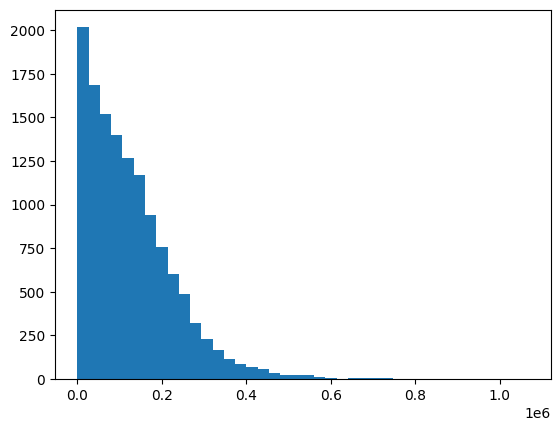

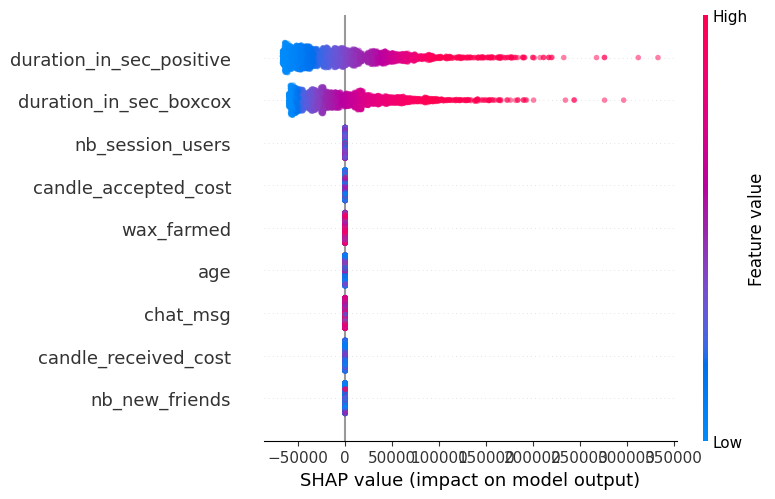

In [ ]:
# Define oneHopFeatures and initialize nonNeighborData
oneHopFeatures = [
    "nb_session_users",
    "candle_accepted_cost", "candle_received_cost"
]
nonNeighborData = svdata.copy()
for j, feature in enumerate(oneHopFeatures):
    feature_index = svdata.columns.get_loc(feature)
    nonNeighborData.iloc[:, feature_index] = EmptyNeighborhoodFeatureValues[j]
estimatedNoSocialY = rf.predict(nonNeighborData.iloc[:, c])

# Calculate temporary data and network power
temp = svdata.iloc[:, targetVariable] - estimatedNoSocialY
data = [svdata.iloc[:, idColumn], temp.mask(temp < 0, 0)]
networkPowerFull = pd.concat(data, axis=1)
networkPowerFull.columns = ['dest', 'NetworkPower_dest']
print(networkPowerFull.head())

# Adjust ndata column names based on actual number of columns
if ndata.shape[1] == 3:
    ndata.columns = ['src', 'dest', 'weight']
elif ndata.shape[1] == 4:
    ndata.columns = ['index', 'src', 'dest', 'weight']
else:
    raise ValueError(f"ndata has unexpected number of columns: {ndata.shape[1]}")

# Group and merge operations
grouped = ndata.groupby('dest').aggregate(np.sum).reset_index()
grouped = grouped.drop(columns=['src'], errors='ignore')

ResultsFileName = "SVResults_Asian.csv"
nndata = ndata.merge(grouped, how='left', on='dest', suffixes=['_pair', '_sumForDest'])
nndata['normalized_ew'] = nndata['weight_pair'] / nndata['weight_sumForDest']
nndata.fillna(0, inplace=True)

# Calculate expected social value results
ewsvresult = nndata.merge(networkPowerFull, how='left', on='dest')
ewsvresult['ewsv'] = ewsvresult['normalized_ew'] * ewsvresult['NetworkPower_dest']

# Prepare output data
tempdf = pd.DataFrame({
    'source': ewsvresult['src'],
    'dest': ewsvresult['dest'],
    'sv': ewsvresult['ewsv']
})
tempdf.to_csv(ResultsFileName[:-4] + "_directed_sv.csv", header=True, index=None)

# Aggregating social and influence values
svresult = ewsvresult.groupby('src').aggregate(np.sum).reset_index()
svresult = pd.DataFrame({'userID': svresult['src'], 'SocialValue': svresult['ewsv']})

infresult = ewsvresult.groupby('dest').aggregate(np.sum).reset_index()
infresult = pd.DataFrame({'userID': infresult['dest'], 'Influenceability': infresult['ewsv']})

psresult = pd.DataFrame({
    'userID': svdata.iloc[:, idColumn],
    'PersonalSpend': svdata.iloc[:, targetVariable]
})

# Merging results into final table
merge1 = svresult.merge(psresult, on="userID", how="outer").fillna(0)
resultstable = merge1.merge(infresult, on="userID", how="outer").fillna(0)
resultstable['AsocialValue'] = resultstable['PersonalSpend'] - resultstable['Influenceability']
resultstable['NetworkPower'] = resultstable['AsocialValue'] + resultstable['SocialValue']
resultstable['TotalValue'] = resultstable['SocialValue'] + resultstable['AsocialValue'] + resultstable['Influenceability']

# Calculating statistics
metric_stat = ["Social Value", "Asocial Value", "Influenceability", "Network Power", "Personal Spend", "Total Value"]
minimum = [resultstable[col].min() for col in ['SocialValue', 'AsocialValue', 'Influenceability', 'NetworkPower', 'PersonalSpend', 'TotalValue']]
maximum = [resultstable[col].max() for col in ['SocialValue', 'AsocialValue', 'Influenceability', 'NetworkPower', 'PersonalSpend', 'TotalValue']]
std = [resultstable[col].std() for col in ['SocialValue', 'AsocialValue', 'Influenceability', 'NetworkPower', 'PersonalSpend', 'TotalValue']]
mean = [resultstable[col].mean() for col in ['SocialValue', 'AsocialValue', 'Influenceability', 'NetworkPower', 'PersonalSpend', 'TotalValue']]
total = [resultstable[col].sum() for col in ['SocialValue', 'AsocialValue', 'Influenceability', 'NetworkPower', 'PersonalSpend', 'TotalValue']]

stat_df = pd.DataFrame({
    'Metric': metric_stat,
    'Min': minimum,
    'Max': maximum,
    'Std': std,
    'Mean': mean,
    'Total': total
})

# Social percentage calculation
social_percentage = sum(resultstable['SocialValue']) / (sum(resultstable['SocialValue']) + sum(resultstable['AsocialValue']))

# Save results
resultstable.to_csv(ResultsFileName, header=True, index=None)
ret = (stat_df, social_percentage * 100, r2_score, accuracy_perc)

# Output results
print("Statistical DataFrame:\n", stat_df)
print("Social Percentage:", social_percentage * 100)
print("R2 Score:", r2_score)
print("Accuracy Percentage:", accuracy_perc)

# Plotting and SHAP analysis
plt.hist(y_actual, bins=40)
plt.show()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, alpha=0.5)


In [ ]:
resultstable.head()
resultstable.to_csv('sky_SV_data')

In [ ]:
stat_df

,Metric,Min,Max,Std,Mean,Total
0,Social Value,0.0,4.609905e+03,92.858080,18.999775,2.498850e+05
1,Asocial Value,0.0,1.012839e+06,106122.972980,125898.115036,1.655812e+09
2,Influenceability,0.0,5.596787e+04,693.502060,18.999775,2.498850e+05
3,Network Power,0.0,1.012874e+06,106137.821150,125917.114811,1.656062e+09
4,Personal Spend,0.0,1.067140e+06,106226.347390,125917.114811,1.656062e+09
5,Total Value,0.0,1.067175e+06,106241.187825,125936.114586,1.656312e+09
